### Foundation Machine Learning - LAB 10 

###  Name : Sudharsan Tirumal
###  ID   : 8977532

### Load the Required libraries

In [50]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

### Load the Dog vs Cat Dataset

In [37]:
train_data = image_dataset_from_directory(directory='dataset/training_set',
                                                      labels='inferred',
                                                      batch_size=32,
                                                      image_size=(256, 256))

Found 8000 files belonging to 2 classes.


In [38]:
test_data = keras.utils.image_dataset_from_directory(directory='dataset/test_set',
                                                      labels='inferred',
                                                      label_mode='int',
                                                      batch_size=32,
                                                      image_size=(256, 256))

Found 2000 files belonging to 2 classes.


### EDA - Explore the data 

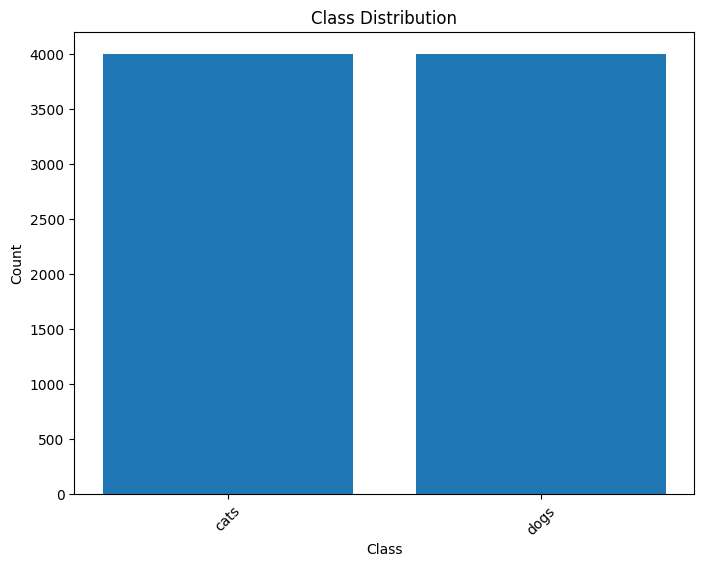

In [73]:
plt.figure(figsize=(8, 6))
class_counts = np.zeros(num_classes)
for images, labels in train_data:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)
plt.bar(range(num_classes), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(range(num_classes), train_data.class_names, rotation=45)
plt.show()

In [39]:
class_names = train_data.class_names
num_classes = len(class_names)
num_classes

2

###  Display some sample images

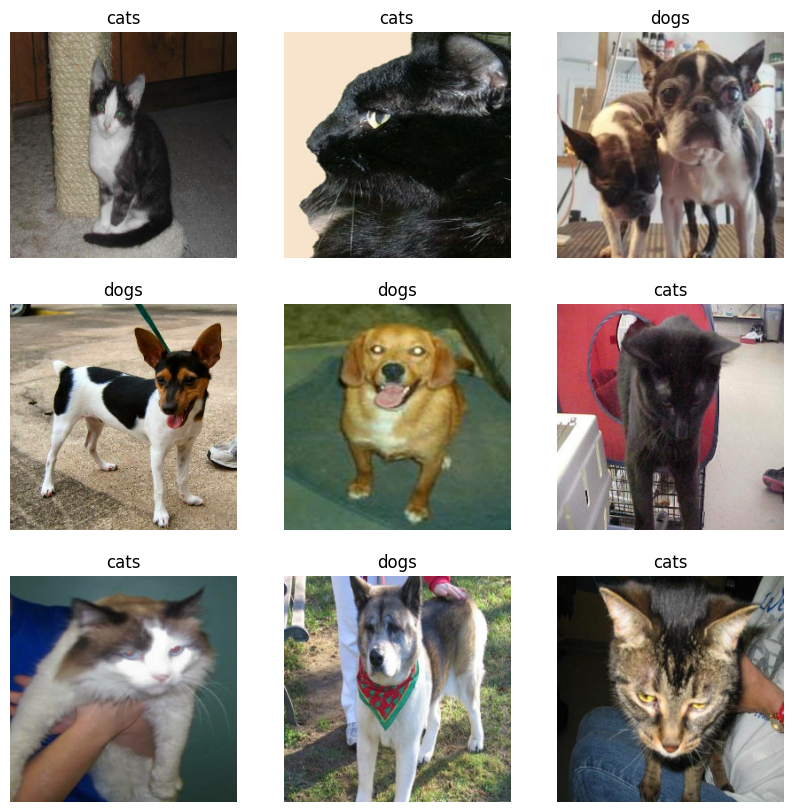

In [40]:
# Display some sample images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Training Two Neural Networks: Comparison of Custom CNN and Fine-Tuned VGG16

#### CNN: 
    A CNN architecture is defined for the first network, providing freedom in design decisions about the number of layers, kinds of activation functions, and kernel sizes. In order to save the optimal model version depending on validation performance, the model is trained on the dataset using callbacks.


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
# Define the CNN architecture
def create_simple_cnn(input_shape, num_classes):
    model = models.Sequential()
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten layer
    model.add(layers.Flatten())
    # Fully connected layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [47]:
# Define input shape and number of classes
input_shape = (256, 256, 3)  # Assuming images are resized to 256x256 RGB
num_classes = 2  # Two classes: dogs and cats

# Create the CNN model
simple_cnn_model = create_simple_cnn(input_shape, num_classes)



In [48]:
# Compile the model
simple_cnn_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])


### Display model summary

In [49]:
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

#### VGG16 Model Fine-Tuning: 
    The second network uses transfer learning to fine-tune the VGG16 model that was previously trained on ImageNet. This method makes use of the characteristics discovered from a sizable dataset and customizes them for the particular job at hand. Overfitting is kept an eye on via validation, and the performance of the training and validation processes are displayed on the relevant graphs.



In [51]:
# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add new fully connected layers on top
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

58889256/58889256 [==============================] - 39s 1us/step


### Data Augmentation

In [52]:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

###  VGG16 model architecture

In [53]:
# Define a smaller model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with a reduced learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training History: Fine-Tuning VGG16 with Data Augmentation

In [55]:
history = model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)),
                    validation_data=test_data,
                    epochs=5,
                    verbose=1)

Epoch 1/5
250/250 [==============================] - 8488s 34s/step - loss: 2.4389 - accuracy: 0.6136 - val_loss: 0.6125 - val_accuracy: 0.6570
Epoch 2/5
250/250 [==============================] - 8245s 33s/step - loss: 0.5794 - accuracy: 0.7015 - val_loss: 0.5951 - val_accuracy: 0.6940
Epoch 3/5
250/250 [==============================] - 8303s 33s/step - loss: 0.5559 - accuracy: 0.7172 - val_loss: 0.5197 - val_accuracy: 0.7380
Epoch 4/5
250/250 [==============================] - 8449s 34s/step - loss: 0.5178 - accuracy: 0.7444 - val_loss: 0.5381 - val_accuracy: 0.7265
Epoch 5/5
250/250 [==============================] - 8628s 35s/step - loss: 0.5104 - accuracy: 0.7552 - val_loss: 0.4998 - val_accuracy: 0.7590


#### Plot training and validation accuracy

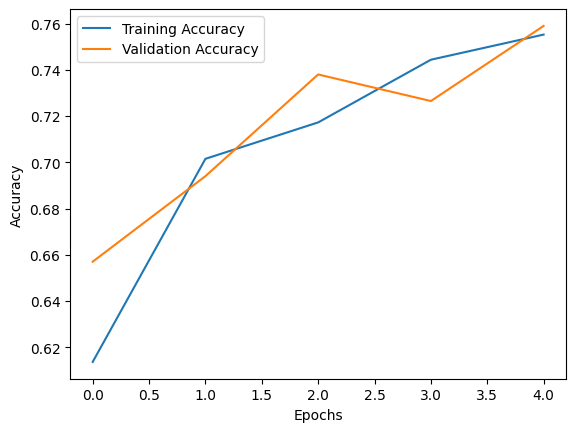

In [56]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Plot training and validation loss

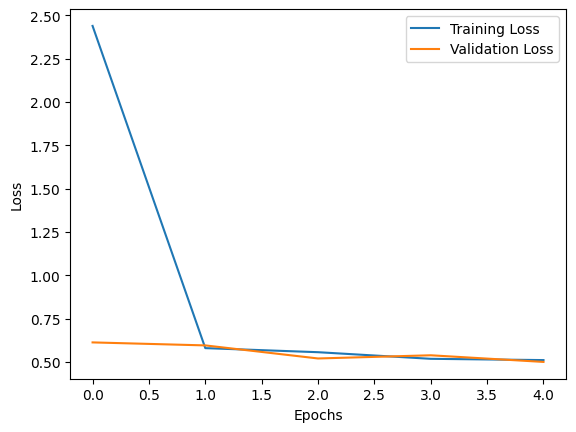

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Explore the relative performance of the models

In [58]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

#### Evaluate the model

In [61]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')

# Confusion matrix
predictions = model.predict(test_data)
y_pred = np.round(predictions).flatten()
y_true = np.concatenate([y for x, y in test_data], axis=0)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


63/63 [==============================] - 628s 10s/step - loss: 0.4998 - accuracy: 0.7590
Test Accuracy: 0.7590000033378601
63/63 [==============================] - 628s 10s/step
Confusion Matrix:
[[518 482]
 [502 498]]


#### Precision, recall, F1-score

In [62]:
# Precision, recall, F1-score
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.51      0.52      0.51      1000
     Class 1       0.51      0.50      0.50      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



#### Precision-recall curve

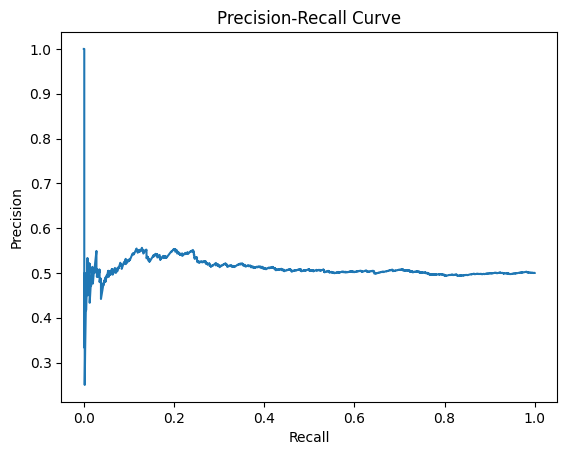

In [63]:

precision, recall, _ = precision_recall_curve(y_true, predictions)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### Explore specific examples in which the model failed to predict correctly

1/1 [==============================] - 10s 10s/step


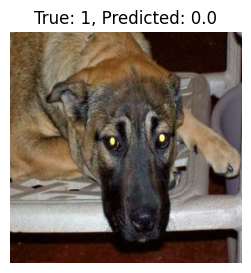

In [70]:
# Choose a random index from the test dataset
random_index = random.randint(0, len(test_data)-1)

# Extract a single data point from the test dataset
for images, labels in test_data.skip(random_index).take(1):  # Skip to the random index and take one batch
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten()
    for i in range(len(predicted_labels)):
        if predicted_labels[i] != labels[i]:
            plt.figure(figsize=(6, 3))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {labels[i]}, Predicted: {predicted_labels[i]}")
            plt.axis("off")
            plt.show()
            break  # Stop after finding the first misclassification
    else:
        print("No misclassification found in this batch.")


1/1 [==============================] - 10s 10s/step


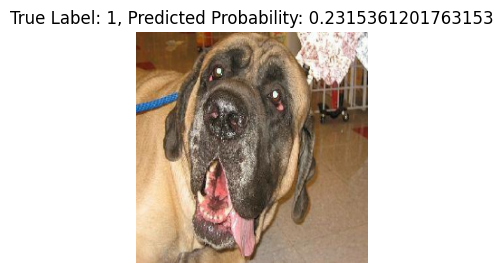

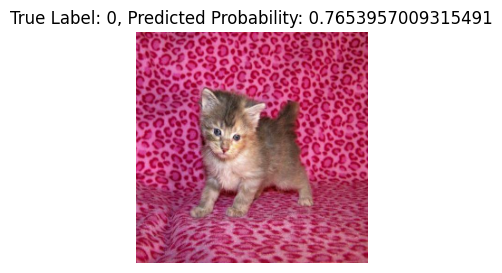

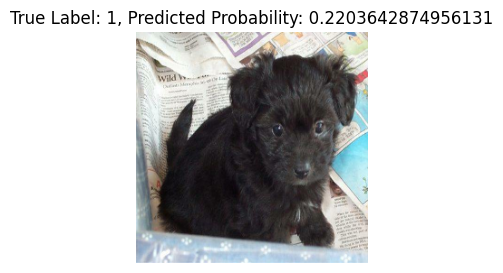

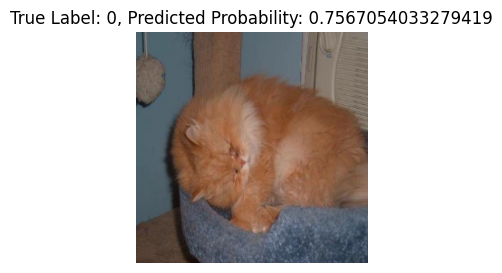

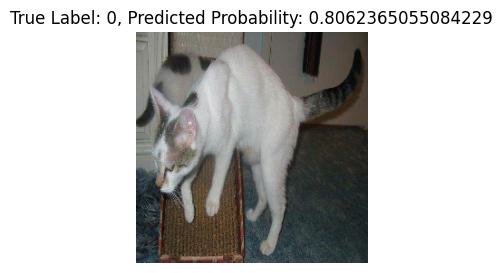

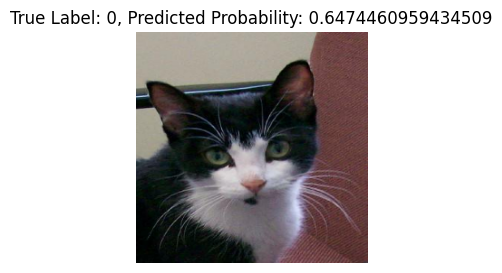

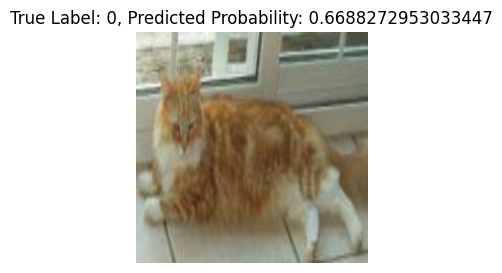

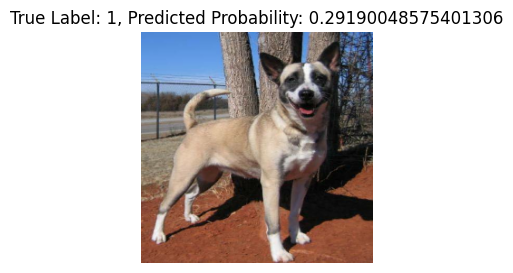

In [71]:
# Display the misclassified image along with the prediction
for images, labels in test_data.take(1):
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten()
    for i in range(len(predicted_labels)):
        if predicted_labels[i] != labels[i]:
            plt.figure(figsize=(6, 3))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True Label: {labels[i]}, Predicted Probability: {predictions[i][0]}")
            plt.axis("off")
            plt.show()


#### Result :
     The image was actually from group 1, even though the model believed it to be from group 0. This indicates a confusion   in the model. It's possible that it overlooked crucial information in the image that would have identified which group   it is in. To understand why the model made this error, we need to examine the image and model more closely.